In [10]:
import pandas as pd
import numpy as np
import re

# 데이터 로드
file_path = './wine_review.csv'  # 데이터 파일 경로
df = pd.read_csv(file_path)

# 결측값 처리: 리뷰 텍스트와 레이팅이 없는 행 제거
df.dropna(subset=['reviews.text', 'reviews.rating'], inplace=True)

# 불필요한 열 제거
columns_to_drop = ['id', 'asins', 'brand', 'categories', 'dateAdded', 'dateUpdated', 
                   'descriptions', 'dimension', 'ean', 'flavors', 'keys', 
                   'manufacturer', 'manufacturerNumber', 'name', 'reviews.date', 
                   'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 
                   'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 
                   'reviews.sourceURLs', 'reviews.userCity', 
                   'reviews.userProvince', 'reviews.username', 'sizes', 
                   'sourceURLs', 'upc', 'weight']
df = df.drop(columns=columns_to_drop)

# reviews.text와 reviews.title을 합쳐서 reviews 열 생성
df['reviews'] = df['reviews.text'].fillna('') + ' ' + df['reviews.title'].fillna('')

# 기존의 reviews.text와 reviews.title 열 삭제
df.drop(columns=['reviews.text', 'reviews.title'], inplace=True)

# 텍스트 전처리 함수 (간단히 소문자 변환 및 불필요한 문자 제거)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # 문자와 공백만 남기기
    text = ' '.join(text.split())  # 공백 처리
    return text

# 리뷰 텍스트 전처리 적용
df['cleaned_reviews'] = df['reviews'].apply(preprocess_text)

# reviews.rating이 3.0인 행 제거
df = df[df['reviews.rating'] != 3.0]

# 평점이 4, 5인 리뷰에는 레이블 1을, 평점이 1, 2인 리뷰에는 레이블 0을 부여, 부여된 레이블은 새로 생성한 label이라는 열에 저장
df['label'] = np.where(df['reviews.rating'] > 3, 1, 0)

# 최종 데이터 생성
df.to_csv(r"./wine_review_filtered_svr.csv", index = False)




In [14]:
# 필요한 라이브러리 불러오기
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score


# 전처리된 데이터 불러오기
df = pd.read_csv("./wine_review_filtered_svr.csv")

# 특성과 레이블 분리하기
X = df['cleaned_reviews']
y = df['reviews.rating']  # 레이블을 'reviews.rating'으로 변경

# 학습 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF 벡터화를 사용하여 텍스트 데이터 변환하기
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# SVR 모델 초기화 및 하이퍼파라미터 그리드 정의
svr_regressor = SVR()
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}


# GridSearchCV 초기화 및 하이퍼파라미터 튜닝
grid_search = GridSearchCV(svr_regressor, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train_vectorized, y_train)

# 최적의 모델로 테스트 데이터 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_vectorized)

# 최적의 하이퍼파라미터와 최적의 모델
print(f'최적의 하이퍼파라미터: {grid_search.best_params_}')
print(f'최적의 교차 검증 MSE: {grid_search.best_score_:.2f}')

# 회귀 평가 지표 계산
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'평균 제곱 오차 (MSE): {mse:.2f}')
print(f'R^2 점수: {r2:.2f}')

# 예측값을 이진 분류 레이블로 변환
y_pred_binary = (y_pred >= 3.5).astype(int)
# 실제 데이터의 레이블을 직접 사용
y_test_binary = (y_test >= 3.5).astype(int)

# 모델 평가 지표 계산
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)
roc_auc = roc_auc_score(y_test_binary, y_pred_binary)

print(f'정확도: {accuracy:.2f}')
print(f'정밀도: {precision:.2f}')
print(f'재현율: {recall:.2f}')
print(f'F1 점수: {f1:.2f}')
print(f'ROC-AUC 점수: {roc_auc:.2f}')




최적의 하이퍼파라미터: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
최적의 교차 검증 MSE: -0.46
평균 제곱 오차 (MSE): 0.48
R^2 점수: 0.28
정확도: 0.96
정밀도: 0.96
재현율: 1.00
F1 점수: 0.98
ROC-AUC 점수: 0.61


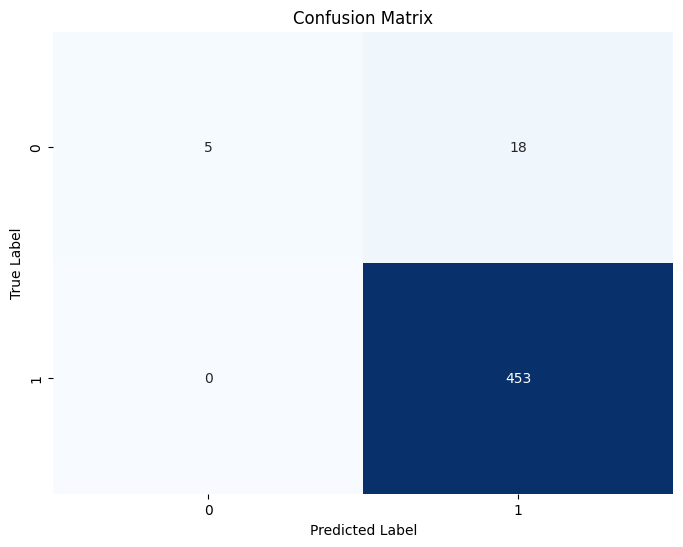

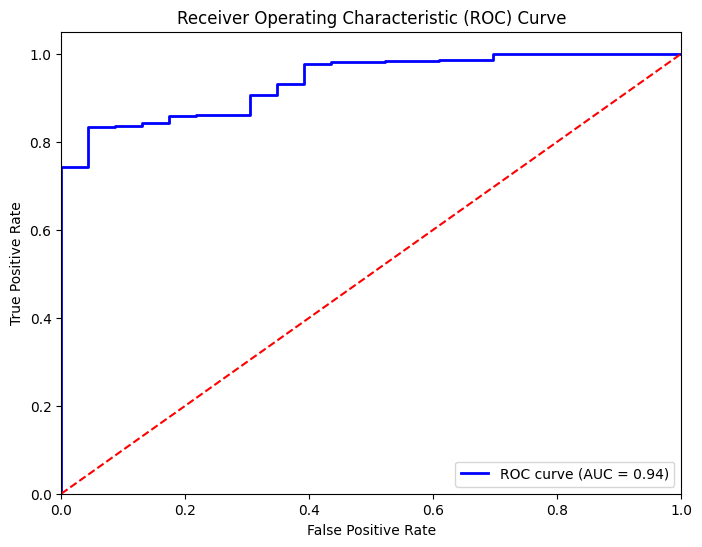

In [22]:
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC 곡선 생성
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()